In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
# from torchvision import datasets

def cuda_check():
    return "CUDA ON" if torch.cuda.is_available() else "No CUDA :("

In [2]:
cuda_check()

'CUDA ON'

In [3]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
train.shape, test.shape

((42000, 785), (28000, 784))

In [4]:
transform = transforms.Compose([transforms.Normalize([0.5], [0.5]),
                                transforms.ToTensor()])

data = np.concatenate((np.array(train)[:, 1:], np.array(test)), axis=0)
# data = data.reshape(70000, 28, 28)
data.shape

(70000, 784)

In [5]:
class MNIST(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            return np.asarray(self.transform(self.data[index,]))
        else:
            return np.asarray(self.data[index, ])
    
    def __len__(self):
        return self.data.shape[0]
    
dataset = MNIST(data, transform=False)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Linear(784, 512)
#         self.layer2 = nn.Linear(1024, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 1)
        self.drop = nn.Dropout(0.25)
        
    def forward(self, x):
        x = F.leaky_relu(self.layer1(x), 0.2)
        x = self.drop(x)
        x = F.leaky_relu(self.layer2(x), 0.2)
        x = self.drop(x)
#         x = F.leaky_relu(self.layer3(x), 0.2)
#         x = self.drop(x)
        x = F.sigmoid(self.layer3(x))
        return x
        
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Linear(100, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 512)
        self.layer4 = nn.Linear(512, 1024)
        self.layer5 = nn.Linear(1024, 28*28)
        self.batch1 = nn.BatchNorm1d(128, 0.8)
        self.batch2 = nn.BatchNorm1d(256, 0.8)
        self.batch3 = nn.BatchNorm1d(512, 0.8)
        self.batch4 = nn.BatchNorm1d(1024, 0.8)
        
    def forward(self, x):
        x = F.leaky_relu(self.batch1(self.layer1(x)), 0.2)
        x = F.leaky_relu(self.batch2(self.layer2(x)), 0.2)
        x = F.leaky_relu(self.batch3(self.layer3(x)), 0.2)
        x = F.leaky_relu(self.batch4(self.layer4(x)), 0.2)
        x = F.tanh(self.layer5(x))
        return x

In [19]:
D = Discriminator()
G = Generator()
criterion = nn.BCELoss()
D_optim = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optim = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

import random

seed = 11
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [20]:
if torch.cuda.is_available():
    print("Training on CUDA")
    D.cuda()
    G.cuda()
else:
    print("Where is my GPU????")

from torch.autograd import Variable
import time

epochs=20
batch_size=16

for e in range(epochs):
    
    t0 = time.time()
    print("Running on epoch {}".format(e+1))
    
    DLOSS = 0
    GLOSS = 0
    
    for real_data in dataloader:
        real_data = real_data.cuda().float()
        target_real = Variable(torch.ones(batch_size, 1)).cuda()
        target_fake = Variable(torch.zeros(batch_size, 1)).cuda()

        D_real = D(real_data)
        D_real_loss = criterion(D_real, target_real)

        
        z = Variable(torch.randn(batch_size, 100)).cuda()
        fake_data = G(z)
        
        D_fake = D(fake_data)
        D_fake_loss = criterion(D_fake, target_fake)
        
        D_Loss = D_real_loss + D_fake_loss
        
        D_optim.zero_grad()
        D_Loss.backward()
        D_optim.step()
        
        z = Variable(torch.randn(batch_size, 100)).cuda()
        fake_data = G(z)
        D_fake = D(fake_data)
        G_Loss = criterion(D_fake, target_real)
        
        G_optim.zero_grad()
        G_Loss.backward()
        G_optim.step()
        
        DLOSS += D_Loss.item()
        GLOSS += G_Loss.item()
        
    t1 = time.time()
    print("Discriminator Loss: {:.3f}".format(DLOSS/len(dataloader)))
    print("Generator Loss: {:.3f}".format(GLOSS/len(dataloader)))
    print("Duration per Epoch: {:.1f}".format((t1-t0)/60))
    print()

Training on CUDA
Running on epoch 1
Discriminator Loss: 0.236
Generator Loss: 3.394
Duration per Epoch: 0.7

Running on epoch 2
Discriminator Loss: 0.041
Generator Loss: 8.796
Duration per Epoch: 0.7

Running on epoch 3
Discriminator Loss: 0.419
Generator Loss: 12.585
Duration per Epoch: 0.7

Running on epoch 4
Discriminator Loss: 0.127
Generator Loss: 15.368
Duration per Epoch: 0.7

Running on epoch 5
Discriminator Loss: 0.205
Generator Loss: 24.462
Duration per Epoch: 0.7

Running on epoch 6
Discriminator Loss: 0.082
Generator Loss: 36.060
Duration per Epoch: 0.7

Running on epoch 7
Discriminator Loss: 0.176
Generator Loss: 49.517
Duration per Epoch: 0.7

Running on epoch 8
Discriminator Loss: 0.353
Generator Loss: 72.213
Duration per Epoch: 0.7

Running on epoch 9
Discriminator Loss: 0.300
Generator Loss: 75.923
Duration per Epoch: 0.7

Running on epoch 10
Discriminator Loss: 0.162
Generator Loss: 78.312
Duration per Epoch: 0.7

Running on epoch 11
Discriminator Loss: 0.009
Generato

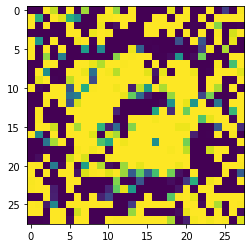

In [22]:
z = Variable(torch.randn(batch_size, 100)).cuda()
t = G(z)
tt = t.cpu().detach().numpy().reshape(16,28,28)
plt.imshow(tt[0])